<a href="https://colab.research.google.com/github/yiwenwangANU/pytorch_review/blob/main/Extra_Debiasing_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From: https://github.com/MITDeepLearning/introtodeeplearning/blob/master/lab2/PT_Part2_Debiasing.ipynb

In [1]:
!pip install mitdeeplearning --quiet
import mitdeeplearning as mdl

In [2]:
!pip install torchinfo
import torchinfo
from torchinfo import summary

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import os
from pathlib import Path
import numpy as np
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

if torch.cuda.is_available():
  device = torch.device("cuda")
  print("GPU ready!")
else:
  device = "cpu"
  print("GPU not available!")

GPU ready!


In [4]:
data_dir = Path.home() / 'data'
os.makedirs(data_dir, exist_ok=True)

data_dir = os.path.join(data_dir, "train_face.h5")
if os.path.exists(data_dir):
  print("Data ready.")
else:
  print(f"Downloading training data to {data_dir}")
  url = "https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1"
  torch.hub.download_url_to_file(url, data_dir)

loader = mdl.lab2.TrainingDatasetLoader(
    data_dir, channels_last=False
)

Data ready.
Opening /root/data/train_face.h5
Loading data into memory...


In [5]:
image, label = loader.get_batch(100)
print(f"Images shape: {image.shape}")  # Shape of the image tensor|
print(f"Labels shape: {label.shape}")  # Shape of the label tensor
print(f"Images data type: {image.dtype}")
print(f"Labels data type: {label.dtype}")
print(f"First image tensor:\n{image[0]}")
print(f"First label tensor: {label[0]}")

Images shape: (100, 3, 64, 64)
Labels shape: (100, 1)
Images data type: float32
Labels data type: float32
First image tensor:
[[[0.38039216 0.4392157  0.47058824 ... 0.53333336 0.5372549  0.50980395]
  [0.39215687 0.3764706  0.41568628 ... 0.5019608  0.49019608 0.43137255]
  [0.36078432 0.37254903 0.35686275 ... 0.49019608 0.42745098 0.40392157]
  ...
  [0.8156863  0.7882353  0.8039216  ... 0.52156866 0.46666667 0.4745098 ]
  [0.8        0.72156864 0.8156863  ... 0.44705883 0.42745098 0.42352942]
  [0.78039217 0.8156863  0.8235294  ... 0.2509804  0.19607843 0.17254902]]

 [[0.41568628 0.4627451  0.49411765 ... 0.56078434 0.56078434 0.5411765 ]
  [0.41960785 0.4117647  0.44705883 ... 0.5176471  0.5019608  0.45490196]
  [0.38431373 0.3882353  0.3764706  ... 0.5176471  0.45490196 0.4509804 ]
  ...
  [0.78431374 0.7529412  0.74509805 ... 0.4509804  0.39607844 0.4392157 ]
  [0.76862746 0.68235296 0.7607843  ... 0.38039216 0.34117648 0.32156864]
  [0.7372549  0.8        0.78039217 ... 0.1686

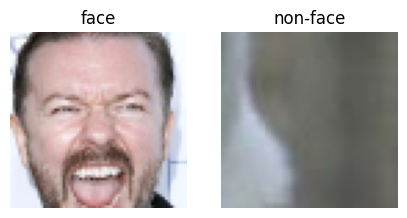

In [6]:
face_images = image[np.where(label == 1)[0]].transpose(0, 2, 3, 1)
non_face_images = image[np.where(label != 1)[0]].transpose(0, 2, 3, 1)

# @title Change the sliders to look at positive and negative training examples! { run: "auto" }
idx_face = 32  # @param {type:"slider", min:0, max:50, step:1}
idx_non_face = 25  # @param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('face')
plt.imshow(face_images[idx_face])

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('non-face')
plt.imshow(non_face_images[idx_non_face])

In [7]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
      super().__init__()
      self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
      self.relu = nn.ReLU(inplace=True)
      self.bn = nn.BatchNorm2d(out_channels)

  def forward(self, x):
      x = self.conv(x)
      x = self.relu(x)
      x = self.bn(x)
      return x

In [8]:
class CNNModel(nn.Module):
  def __init__(self, in_channels, out_channels, n_filters, H, W):
    super().__init__()
    self.layer_stack = nn.Sequential(
      # img output size = (in_channels+1)//2 for in_channels % 2 != 1 img output size = in_channels // 2
      ConvBlock(in_channels, n_filters, kernel_size=5, stride=2, padding=2),
      ConvBlock(n_filters, 2*n_filters, kernel_size=5, stride=2, padding=2), # in_channels / 4
      ConvBlock(2*n_filters, 4*n_filters, kernel_size=3, stride=2, padding=1), # in_channels / 8
      ConvBlock(4*n_filters, 6*n_filters, kernel_size=3, stride=2, padding=1), # in_channels / 16
      nn.Flatten(),
      nn.Linear(H // 16 * W // 16 * 6 * n_filters, 512),
      nn.ReLU(inplace=True),
      nn.Linear(512, out_channels),
  )

  def forward(self, x):
    return self.layer_stack(x)

in_channels, H, W = image.shape[1], image.shape[2], image.shape[3]
model_CNN = CNNModel(in_channels=in_channels, out_channels=1, n_filters=12, H=H, W=W).to(device)

In [9]:
summary(model_CNN, input_size=[1, in_channels, H, W])

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─ConvBlock: 2-1                    [1, 12, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 12, 32, 32]           912
│    │    └─ReLU: 3-2                    [1, 12, 32, 32]           --
│    │    └─BatchNorm2d: 3-3             [1, 12, 32, 32]           24
│    └─ConvBlock: 2-2                    [1, 24, 16, 16]           --
│    │    └─Conv2d: 3-4                  [1, 24, 16, 16]           7,224
│    │    └─ReLU: 3-5                    [1, 24, 16, 16]           --
│    │    └─BatchNorm2d: 3-6             [1, 24, 16, 16]           48
│    └─ConvBlock: 2-3                    [1, 48, 8, 8]             --
│    │    └─Conv2d: 3-7                  [1, 48, 8, 8]             10,416
│    │    └─ReLU: 3-8                    [1, 48, 8, 8]             --
│    │ 

In [10]:
loss_fn = nn.BCEWithLogitsLoss()
# Training hyperparameters
params = dict(
    batch_size=32,
    num_epochs=2,  # keep small to run faster
    learning_rate=5e-4,
)

optimizer = torch.optim.Adam(
    model_CNN.parameters(), lr=params["learning_rate"]
)  # define our optimizer

In [11]:
def train_step(model: torch.nn.Module,
               loader: mdl.lab2.TrainingDatasetLoader,
               batch_size: int,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc, correct = 0, 0, 0
  loader_len = loader.get_train_size()
  # Loop through data loader data batches
  for idx in tqdm(range(loader_len // batch_size)):
    X, y = loader.get_batch(batch_size)
    # Send data to target device
    X = torch.from_numpy(X).float().to(device)
    y = torch.from_numpy(y).float().to(device)

    # 1. Forward pass
    y_logit = model(X)

    # 2. Calculate  and accumulate loss
    loss = loss_fn(y_logit, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumulate accuracy metric across all batches
    y_pred = torch.round(torch.sigmoid(y_logit))
    correct += torch.eq(y_pred, y).sum().item()

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / loader_len
  train_acc = correct / loader_len
  return train_loss, train_acc

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
def test_step(model: torch.nn.Module,
              loader: mdl.lab2.TrainingDatasetLoader,
              batch_size: int,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc, correct = 0, 0, 0

  # Evaluate on a subset of CelebA+Imagenet
  X, y = loader.get_batch(batch_size)
  # Send data to target device
  X = torch.from_numpy(X).float().to(device)
  y = torch.from_numpy(y).float().to(device)

  with torch.inference_mode():
    y_logit = model(X)
    loss = loss_fn(y_logit, y)
    test_loss += loss.item()

    y_pred = torch.round(torch.sigmoid(y_logit))
    correct += torch.eq(y_pred, y).sum().item()

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / batch_size
  test_acc = correct / batch_size
  return test_loss, test_acc

In [13]:
results = {"train_loss": [],
          "train_acc": [],
          "test_loss": [],
          "test_acc": []
           }

step = 0
for epoch in range(params["num_epochs"]):
  train_loss, train_acc = train_step(model_CNN,
                                     loader,
                                     params['batch_size'],
                                     loss_fn,
                                     optimizer,
                                     device)
  test_loss, test_acc = test_step(model_CNN,
                                  loader,
                                  5000,
                                  loss_fn,
                                  device)
  print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
      )

  0%|          | 0/3434 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0006 | train_acc: 0.9938 | test_loss: 0.0000 | test_acc: 0.9970 | 


  0%|          | 0/3434 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.0003 | train_acc: 0.9972 | test_loss: 0.0000 | test_acc: 0.9982 | 


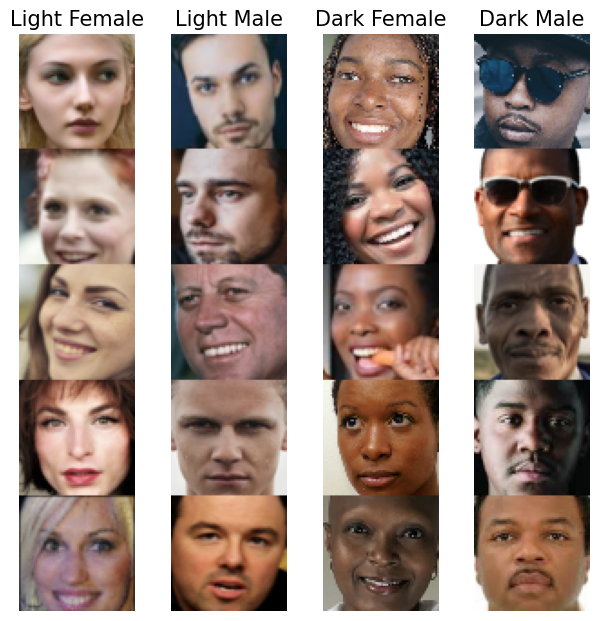

In [14]:
### Load test dataset and plot examples ###

test_faces = mdl.lab2.get_test_faces(channels_last=False)
keys = ["Light Female", "Light Male", "Dark Female", "Dark Male"]

fig, axs = plt.subplots(1, len(keys), figsize=(7.5, 7.5))
for i, (group, key) in enumerate(zip(test_faces, keys)):
    axs[i].imshow(np.hstack(group).transpose(1, 2, 0))
    axs[i].set_title(key, fontsize=15)
    axs[i].axis("off")

In [15]:
torch.from_numpy(np.array(test_faces)).shape

torch.Size([4, 5, 3, 64, 64])

[array([0.9999671 , 0.13784927, 0.6316716 , 0.99839646, 0.9999987 ],
      dtype=float32), array([0.9999167 , 0.1541283 , 0.02062635, 0.9999424 , 0.99973994],
      dtype=float32), array([0.9987478 , 0.9860611 , 0.54908895, 0.9999409 , 0.0053672 ],
      dtype=float32), array([1.6466463e-01, 5.6370622e-01, 3.0528140e-04, 7.9329562e-01,
       9.4832659e-01], dtype=float32)]


Text(0.5, 1.0, 'Standard classifier predictions')

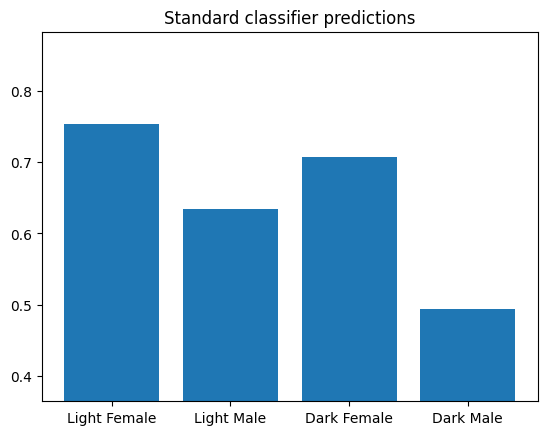

In [16]:
### Evaluate the standard CNN on the test data ###

standard_classifier_probs_list = []  # store each demographic's probabilities

with torch.inference_mode():
    for x in test_faces:
        x = torch.from_numpy(np.array(x, dtype=np.float32)).to(device)
        logits = model_CNN(x)  # [B, 1]
        probs = torch.sigmoid(logits)  # [B, 1]
        probs = torch.squeeze(probs, dim=-1)  # shape [B]
        standard_classifier_probs_list.append(probs.cpu().numpy())
    print(standard_classifier_probs_list[:10]) # near 1 represent is face, near 0 represent not

standard_classifier_probs = np.stack(standard_classifier_probs_list, axis=0)


# Plot the prediction accuracies per demographic
xx = range(len(keys))
yy = standard_classifier_probs.mean(axis=1)  # shape [D]
plt.bar(xx, yy)
plt.xticks(xx, keys)
plt.ylim(max(0, yy.min() - np.ptp(yy) / 2.0), yy.max() + np.ptp(yy) / 2.0)
plt.title("Standard classifier predictions")

Latent loss:
$$L_{KL}(\mu, \sigma^2) = \frac{1}{2}\sum_{j=0}^{k-1} (\sigma_j^2 + \mu_j^2 - 1 - \log{\sigma_j^2})$$

Reconstruction loss:
$$L_{x}{(x,\hat{x})} = ||x-\hat{x}||_1$$

VAE loss:
$$L_{VAE} = c\cdot L_{KL} + L_{x}{(x,\hat{x})}$$

In [29]:
# x in shape of [B, C, W, H], mu in shape of [B, latent space]
def vae_loss_function(x, x_recon, mu, logsigma, kl_weight=0.0005):
    # latent_loss = 0.5 * torch.sum(mu**2 + torch.exp(logsigma)**2 - 1 - 2 * logsigma, dim=1) # shape [B]
    latent_loss = 0.5 * torch.sum(torch.exp(logsigma) + mu**2 - 1 - logsigma, dim=1)
    reconstruction_loss = torch.mean(torch.abs(x - x_recon), dim=(1, 2, 3))

    vae_loss = kl_weight * latent_loss + reconstruction_loss
    return vae_loss

$$z \sim N(\mu,\sigma^2)$$
use resampling track as
$$ z = \mu + \sigma \circ \epsilon$$ where:
$$\epsilon \sim N(0,(I))$$

In [30]:
def sampling(z_mean, z_logsigma):
    # Generate random noise with the same shape as z_mean, sampled from a standard normal distribution (mean=0, std=1)
    eps = torch.randn_like(z_mean) # shape [B, latent space]

    # # TODO: Define the reparameterization computation!
    # # Note the equation is given in the text block immediately above.
    z = z_mean + torch.exp(z_logsigma) * eps # shape [B, latent space]

    return z

For **face images**, our loss function will have two components:


1.   **VAE loss ($L_{VAE}$)**: consists of the latent loss and the reconstruction loss.
2.   **Classification loss ($L_y(y,\hat{y})$)**: standard cross-entropy loss for a binary classification problem.

In contrast, for images of **non-faces**, our loss function is solely the classification loss.

We can write a single expression for the loss by defining an indicator variable ${I}_f$which reflects which training data are images of faces (${I}_f(y) = 1$ ) and which are images of non-faces (${I}_f(y) = 0$). Using this, we obtain:

$$L_{total} = L_y(y,\hat{y}) + {I}_f(y)\Big[L_{VAE}\Big]$$

In [31]:
### Loss function for DB-VAE ###

"""Loss function for DB-VAE.
# Arguments
    x: true input x
    x_recon: reconstructed x
    y: true label (face or not face)
    y_logit: predicted labels
    mu: mean of latent distribution (Q(z|X))
    logsigma: log of standard deviation of latent distribution (Q(z|X))
# Returns
    total_loss: DB-VAE total loss
    classification_loss = DB-VAE classification loss
"""
def debiasing_loss_function(x, x_pred, y, y_logit, mu, logsigma):
    vae_loss = vae_loss_function(x, x_pred, mu, logsigma)
    classification_loss = F.binary_cross_entropy_with_logits(y_logit, y, reduction="none")

    # Use the training data labels to create variable face_indicator:
    #   indicator that reflects which training data are images of faces
    y = y.float()
    face_indicator = (y == 1.0).float()

    total_loss = torch.mean(face_indicator * vae_loss + classification_loss)

    return total_loss, classification_loss

Output of ConvTranspose2d
$$output = (input-1)*stride-2*padding+kernel+ouput padding$$

In [32]:
class DeconvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding, output_padding, last_layer=False):
      super().__init__()
      self.deconv = nn.ConvTranspose2d(
                    in_channels,
                    out_channels,
                    kernel_size,
                    stride,
                    padding,
                    output_padding,
                )
      self.relu = nn.ReLU(inplace=True)
      self.last_layer = last_layer

  def forward(self, x):
      x = self.deconv(x)
      if(self.last_layer):
        return x
      else:
        x = self.relu(x)
        return x

In [33]:
latent_dim=100
n_filters=12

class DecoderModel(nn.Module):
  def __init__(self, latent_dim, n_filters):
    super().__init__()
    self.latent_dim = latent_dim
    self.n_filters = n_filters

    self.linear = nn.Sequential(
        nn.Linear(latent_dim, 4 * 4 * 6 * n_filters), nn.ReLU()
        )
    self.layer_stack = nn.Sequential(
      # [B, 6n_filters, 4, 4] -> [B, 4n_filters, 8, 8]
      DeconvBlock(6 * n_filters, 4 * n_filters, kernel_size=3, stride=2, padding=1, output_padding=1),
      # [B, 4n_filters, 8, 8] -> [B, 2n_filters, 16, 16]
      DeconvBlock(4 * n_filters, 2 * n_filters, kernel_size=3, stride=2, padding=1, output_padding=1),
      # [B, 2n_filters, 16, 16] -> [B, n_filters, 32, 32]
      DeconvBlock(2 * n_filters, n_filters, kernel_size=5, stride=2, padding=2, output_padding=1),
      # [B, n_filters, 32, 32] -> [B, 3, 64, 64]
      DeconvBlock(n_filters, 3, kernel_size=5, stride=2, padding=2, output_padding=1, last_layer=True),
  )

  def forward(self, z):
    x = self.linear(z)  # [B, 4*4*6*n_filters]
    x = x.view(-1, 6 * self.n_filters, 4, 4)  # [B, 6n_filters, 4, 4]
    x = self.layer_stack(x)  # [B, 3, 64, 64] original image shape
    return x



In [34]:
### Defining and creating the DB-VAE ###


class DB_VAE(nn.Module):
    def __init__(self, latent_dim=100):
        super(DB_VAE, self).__init__()
        self.latent_dim = latent_dim

        # Define the number of outputs for the encoder.
        # first dim for y_pred, next 100 dims for mu and last 100 dims for sigma
        self.encoder = CNNModel(in_channels=in_channels, out_channels=2 * latent_dim + 1, n_filters=12, H=H, W=W).to(device)
        self.decoder = DecoderModel(latent_dim, n_filters).to(device)

    # function to feed images into encoder, encode the latent space, and output
    def encode(self, x):
        encoder_output = self.encoder(x)

        # classification prediction
        y_logit = encoder_output[:, 0].unsqueeze(-1) # shape [B, 1]
        # latent variable distribution parameters
        z_mean = encoder_output[:, 1 : self.latent_dim + 1] # shape [B, 100]
        z_logsigma = encoder_output[:, self.latent_dim + 1 :]

        return y_logit, z_mean, z_logsigma

    # VAE reparameterization: given a mean and logsigma, sample latent variables
    def reparameterize(self, z_mean, z_logsigma):
        z = sampling(z_mean, z_logsigma) # shape [B, 100]
        return z

    # Decode the latent space and output reconstruction
    def decode(self, z):
        reconstruction = self.decoder(z) # shape [B, C, W, H]
        return reconstruction

    # The forward function will be used to pass inputs x through the core VAE
    def forward(self, x):
        # Encode input to a prediction and latent space
        y_logit, z_mean, z_logsigma = self.encode(x)
        z = self.reparameterize(z_mean, z_logsigma)
        recon = self.decode(z)

        return y_logit, z_mean, z_logsigma, recon

    # Predict face or not face logit for given input x
    def predict(self, x):
        y_logit, z_mean, z_logsigma = self.encode(x)
        return y_logit

dbvae = DB_VAE(latent_dim)

In [35]:
summary(dbvae, input_size=[1, in_channels, H, W]) # in_channels=3, H=64, W=64

Layer (type:depth-idx)                        Output Shape              Param #
DB_VAE                                        [1, 1]                    --
├─CNNModel: 1-1                               [1, 201]                  --
│    └─Sequential: 2-1                        [1, 201]                  --
│    │    └─ConvBlock: 3-1                    [1, 12, 32, 32]           936
│    │    └─ConvBlock: 3-2                    [1, 24, 16, 16]           7,272
│    │    └─ConvBlock: 3-3                    [1, 48, 8, 8]             10,512
│    │    └─ConvBlock: 3-4                    [1, 72, 4, 4]             31,320
│    │    └─Flatten: 3-5                      [1, 1152]                 --
│    │    └─Linear: 3-6                       [1, 512]                  590,336
│    │    └─ReLU: 3-7                         [1, 512]                  --
│    │    └─Linear: 3-8                       [1, 201]                  103,113
├─DecoderModel: 1-2                           [1, 3, 64, 64]            -

In [36]:
# Function to return the means for an input image batch

def get_latent_mu(images, dbvae, batch_size=64):
    dbvae.eval()
    all_z_mean = []

    # If images is NumPy, convert once outside the loop
    images_t = torch.from_numpy(images).float()

    with torch.inference_mode():
        for start in range(0, len(images_t), batch_size):
            end = start + batch_size
            batch = images_t[start:end]
            batch = batch.to(device).permute(0, 3, 1, 2)
            # Forward pass on this chunk only
            _, z_mean, _, _ = dbvae(batch)
            all_z_mean.append(z_mean.cpu()) # shape [N/B, B, latent_dim]

    # Concatenate all partial z_mean
    z_mean_full = torch.cat(all_z_mean, dim=0)  # shape [N, latent_dim]
    mu = z_mean_full.numpy()  # convert to NumPy if needed
    return mu

In [37]:
### Resampling algorithm for DB-VAE ###

"""Function that recomputes the sampling probabilities for images within a batch
      based on how they distribute across the training data"""
def get_training_sample_probabilities(images, dbvae, bins=10, smoothing_fac=0.001):
    print("Recomputing the sampling probabilities")

    mu = get_latent_mu(images, dbvae) # shape [N, latent_dim]
    # sampling probabilities for the images
    training_sample_p = np.zeros(mu.shape[0], dtype=np.float64) # shape [N]

    # consider the distribution for each latent variable
    for i in range(latent_dim):
        latent_distribution = mu[:, i] # shape [N]
        # generate a histogram of the latent distribution
        hist_density, bin_edges = np.histogram(
            latent_distribution, density=True, bins=bins
        )

        # find which latent bin every data sample falls in
        bin_edges[0] = -float("inf")
        bin_edges[-1] = float("inf")

        # TODO: call the digitize function to find which bins in the latent distribution
        #    every data sample falls in to
        # https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.digitize.html
        bin_idx = np.digitize(latent_distribution, bin_edges) # TODO

        # smooth the density function
        hist_smoothed_density = hist_density + smoothing_fac
        hist_smoothed_density = hist_smoothed_density / np.sum(hist_smoothed_density)

        # p is an array of probabilities for one latent dimension across all images
        p = hist_smoothed_density[bin_idx - 1]
        # invert the density function
        p = 1.0 / p
        # TODO: normalize all probabilities
        p = p / np.sum(p)

        # TODO: update sampling probabilities by considering whether the newly
        #     computed p is greater than the existing sampling probabilities.
        training_sample_p = np.maximum(training_sample_p, p)

    # final normalization
    training_sample_p /= np.sum(training_sample_p)

    return training_sample_p

Starting epoch 1/10
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

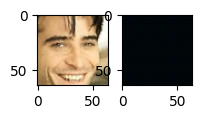

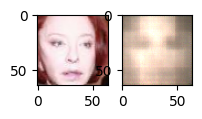

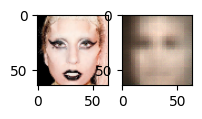

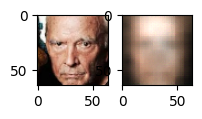

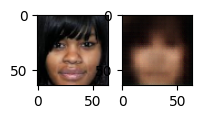

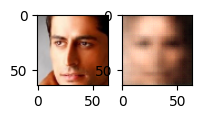

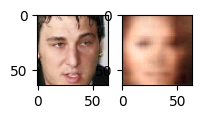

Epoch: 2 | train_loss: 13.5857 | 
Starting epoch 2/10
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

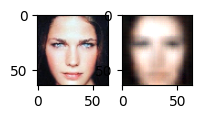

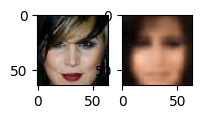

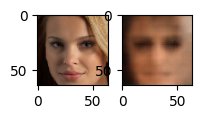

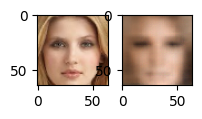

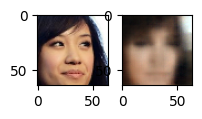

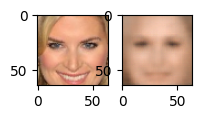

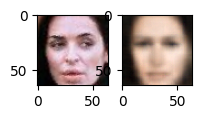

Epoch: 2 | train_loss: 7.4325 | 
Starting epoch 3/10
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

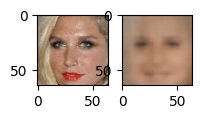

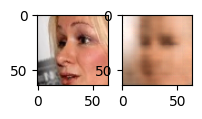

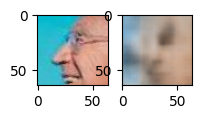

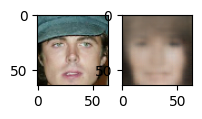

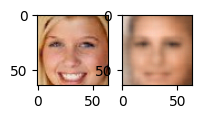

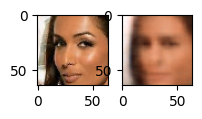

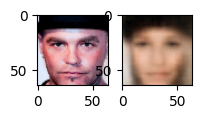

Epoch: 2 | train_loss: 6.4573 | 
Starting epoch 4/10
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

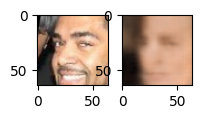

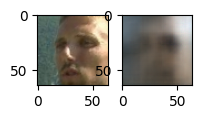

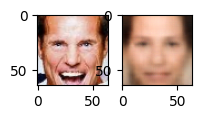

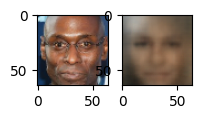

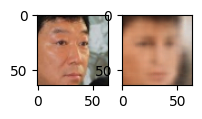

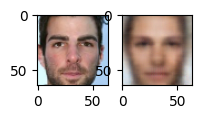

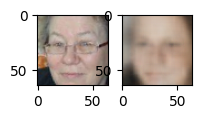

Epoch: 2 | train_loss: 6.1043 | 
Starting epoch 5/10
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

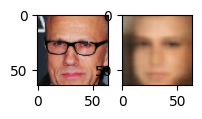

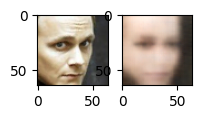

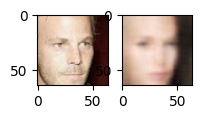

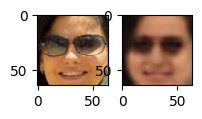

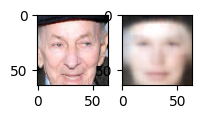

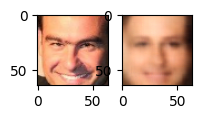

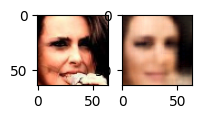

Epoch: 2 | train_loss: 5.9366 | 
Starting epoch 6/10
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

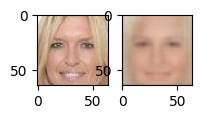

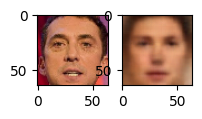

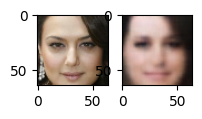

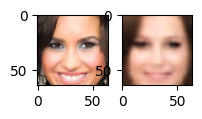

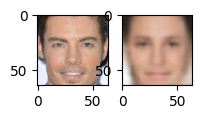

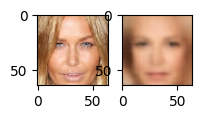

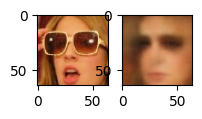

Epoch: 2 | train_loss: 5.7170 | 
Starting epoch 7/10
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

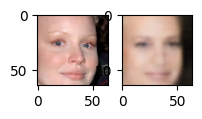

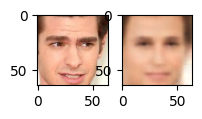

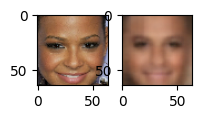

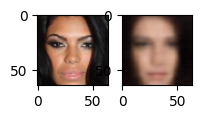

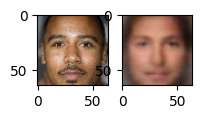

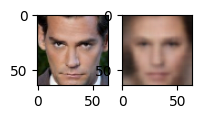

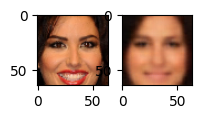

Epoch: 2 | train_loss: 5.5590 | 
Starting epoch 8/10
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

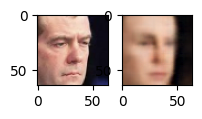

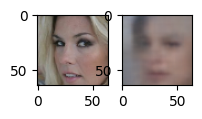

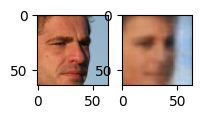

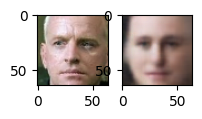

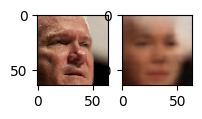

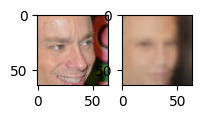

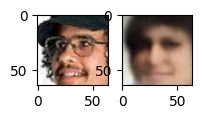

Epoch: 2 | train_loss: 5.4618 | 
Starting epoch 9/10
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

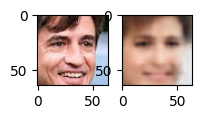

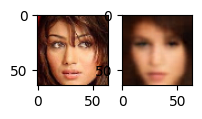

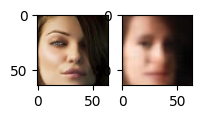

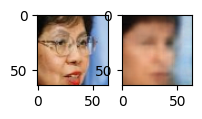

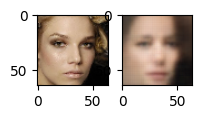

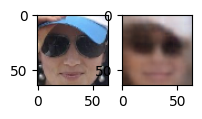

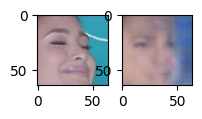

Epoch: 2 | train_loss: 5.3736 | 
Starting epoch 10/10
Recomputing the sampling probabilities


  0%|          | 0/3434 [00:00<?, ?it/s]

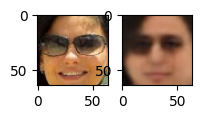

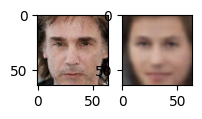

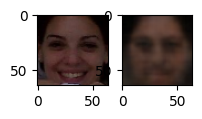

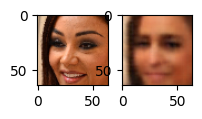

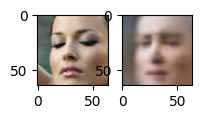

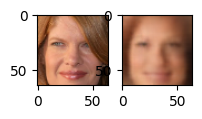

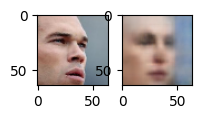

Epoch: 2 | train_loss: 5.3779 | 


In [44]:
### Training the DB-VAE ###

# Hyperparameters
params = dict(
    batch_size=32,
    learning_rate=5e-4,
    latent_dim=100,
    num_epochs=10,  # DB-VAE needs slightly more epochs to train
)


# instantiate a new DB-VAE model and optimizer
dbvae = DB_VAE(params["latent_dim"]).to(device)
optimizer = torch.optim.Adam(dbvae.parameters(), lr=params["learning_rate"])


def debiasing_train_step(x, y):
    optimizer.zero_grad()

    y_logit, z_mean, z_logsigma, x_recon = dbvae(x)

    loss, class_loss = debiasing_loss_function(x, x_recon, y, y_logit, z_mean, z_logsigma) # TODO

    loss.backward()
    optimizer.step()

    return loss


# get training faces from data loader
all_faces = loader.get_all_train_faces()

# The training loop -- outer loop iterates over the number of epochs
for i in range(params["num_epochs"]):
    print("Starting epoch {}/{}".format(i + 1, params["num_epochs"]))

    # Recompute data sampling proabilities
    train_loss = 0
    p_faces = get_training_sample_probabilities(all_faces, dbvae) # TODO

    # get a batch of training data and compute the training step
    for j in tqdm(range(loader.get_train_size() // params["batch_size"])):
        # load a batch of data
        (x, y) = loader.get_batch(params["batch_size"], p_pos=p_faces)
        x = torch.from_numpy(x).float().to(device)
        y = torch.from_numpy(y).float().to(device)

        # loss optimization
        loss = debiasing_train_step(x, y)
        loss_value = loss.detach().cpu().numpy()
        train_loss += loss_value
        if j % 500 == 0:
          mdl.util.plot_sample(x, y, dbvae, backend="pt")


    train_loss = train_loss / params["batch_size"]
    print(f"Epoch: {i+1} | "
          f"train_loss: {train_loss:.4f} | ")

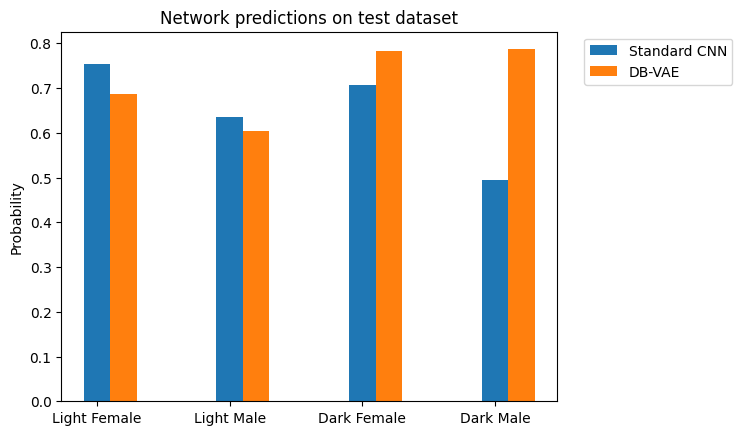

In [45]:
dbvae.to(device)
dbvae_logits_list = []
for face in test_faces:
    face = np.asarray(face, dtype=np.float32)
    face = torch.from_numpy(face).to(device)

    # Forward pass to get the classification logit
    with torch.inference_mode():
        logit = dbvae.predict(face)

    dbvae_logits_list.append(logit.detach().cpu().numpy())

dbvae_logits_array = np.concatenate(dbvae_logits_list, axis=0)
dbvae_logits_tensor = torch.from_numpy(dbvae_logits_array)
dbvae_probs_tensor = torch.sigmoid(dbvae_logits_tensor)
dbvae_probs_array = dbvae_probs_tensor.squeeze(dim=-1).numpy()

xx = np.arange(len(keys))

std_probs_mean = standard_classifier_probs.mean(axis=1)
dbvae_probs_mean = dbvae_probs_array.reshape(len(keys), -1).mean(axis=1)

plt.bar(xx, std_probs_mean, width=0.2, label="Standard CNN")
plt.bar(xx + 0.2, dbvae_probs_mean, width=0.2, label="DB-VAE")

plt.xticks(xx, keys)
plt.title("Network predictions on test dataset")
plt.ylabel("Probability")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()